In [3]:
# Check all members of NorCPM1 to see whether they all have stripes of NaNs or a single one.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
from scipy.interpolate import griddata
import matplotlib as mpl

In [2]:
# Define the variable of interest and its units and range of validity.

varname = 'tas' # We can compute its trend and compare it to the MMM with fig1 here https://www.nature.com/articles/s41612-023-00410-6 (Zhang et al., npjCAS, 2023)
description = '2m air temperature'
units = 'K'
levels = np.arange(235,325,10)

In [3]:
path2era5 = '/bdd/ERA5/NETCDF/GLOBAL_025/1xmonthly/AN_SF/' # Soil Moisture is not already downloaded, but here the t2m, sstk and msl monthly fields are available.
path2cmip6 = '/bdd/CMIP6/CMIP/'

In [4]:
# Read a single ERA5 file to get the coordinates.
ds_era5 = xr.open_dataset(path2era5+'2020/t2m.2020.asme5.GLOBAL_025.nc')
lon = ds_era5.longitude.values
lat = ds_era5.latitude.values

Number of ensemble members: 30
---------------------
r2i1p1f1 has 6489 NaN pixels
r5i1p1f1 has 6489 NaN pixels
r12i1p1f1 has 6489 NaN pixels
r1i1p1f1 has 6489 NaN pixels
r28i1p1f1 has 477288 NaN pixels
r14i1p1f1 has 6489 NaN pixels
r4i1p1f1 has 477288 NaN pixels
r20i1p1f1 has 6489 NaN pixels
r15i1p1f1 has 6489 NaN pixels
r16i1p1f1 has 477288 NaN pixels
r3i1p1f1 has 477288 NaN pixels
r21i1p1f1 has 6489 NaN pixels
r26i1p1f1 has 477288 NaN pixels
r23i1p1f1 has 6489 NaN pixels
r19i1p1f1 has 477288 NaN pixels
r24i1p1f1 has 6489 NaN pixels
r13i1p1f1 has 477288 NaN pixels
r22i1p1f1 has 6489 NaN pixels
r9i1p1f1 has 477288 NaN pixels
r29i1p1f1 has 6489 NaN pixels


<ipython-input-7-5f82a0e37cf9>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(14,6))


r8i1p1f1 has 6489 NaN pixels
r10i1p1f1 has 477288 NaN pixels
r25i1p1f1 has 477288 NaN pixels
r7i1p1f1 has 477288 NaN pixels
r17i1p1f1 has 477288 NaN pixels
r18i1p1f1 has 6489 NaN pixels
r30i1p1f1 has 6489 NaN pixels
r11i1p1f1 has 477288 NaN pixels
r6i1p1f1 has 6489 NaN pixels
r27i1p1f1 has 6489 NaN pixels


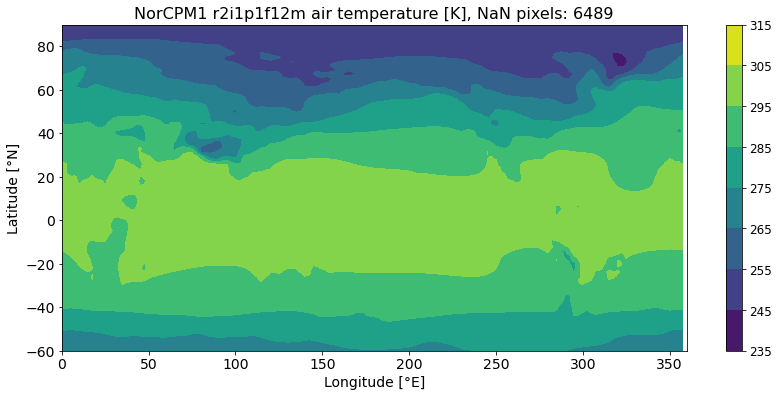

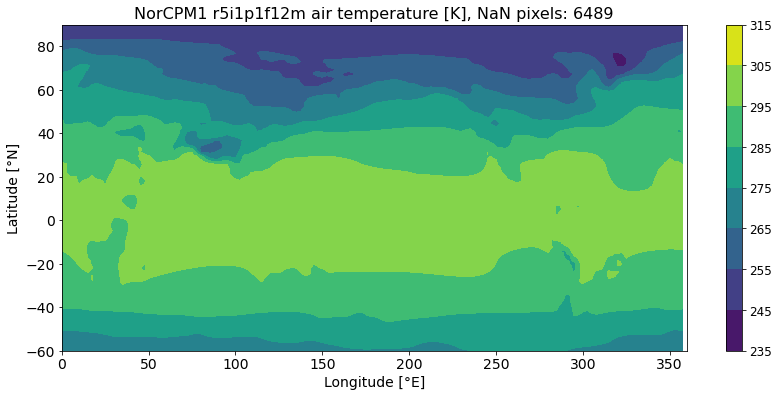

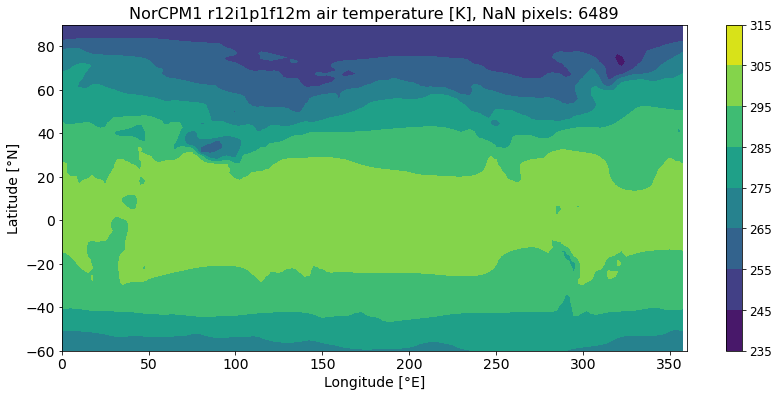

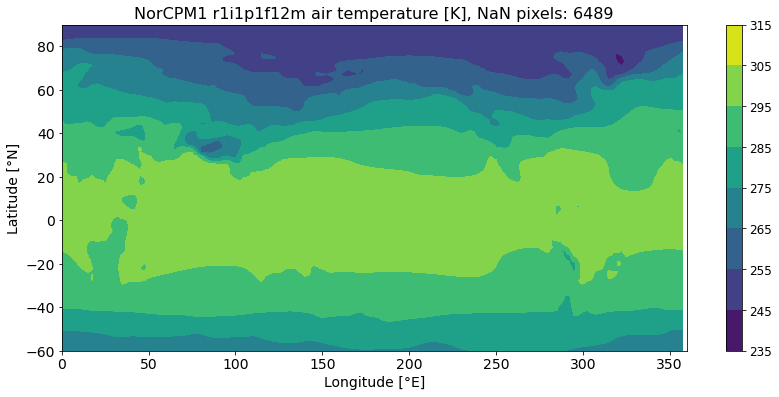

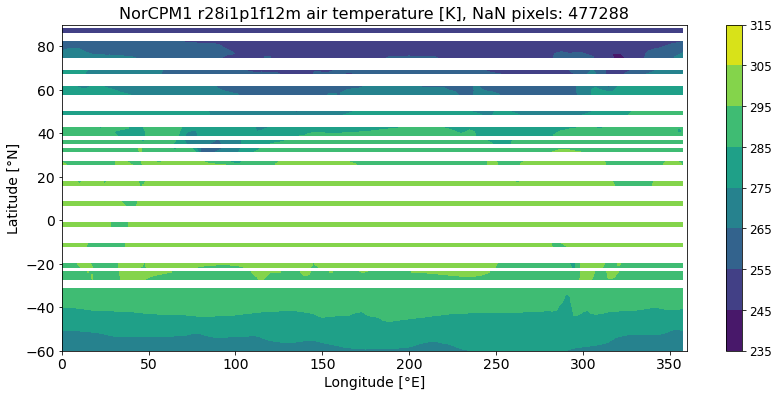

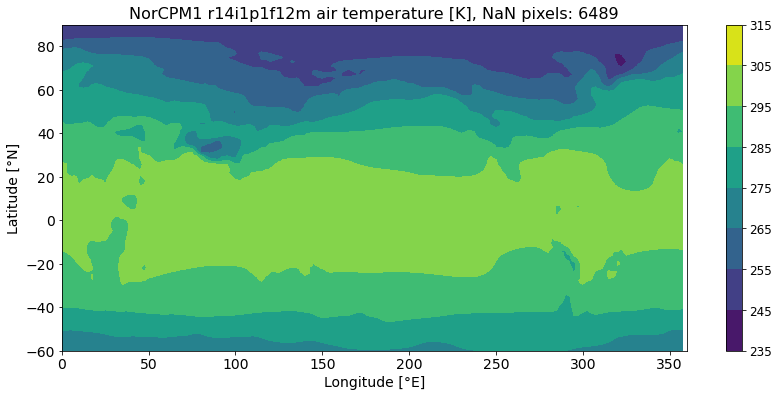

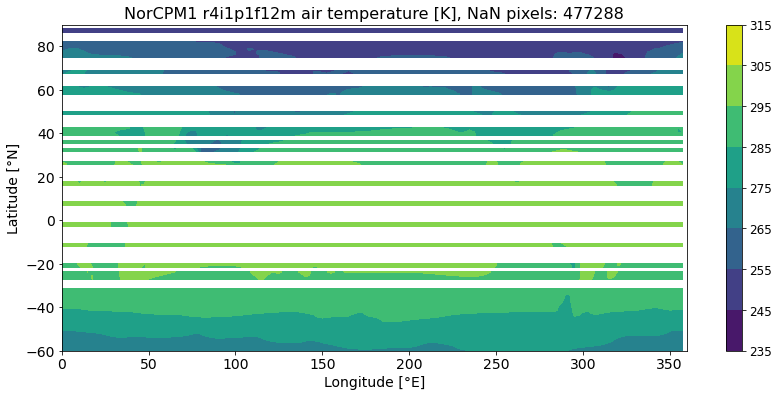

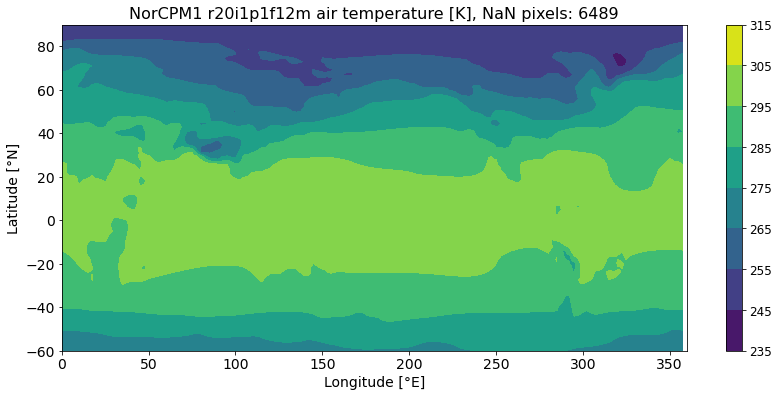

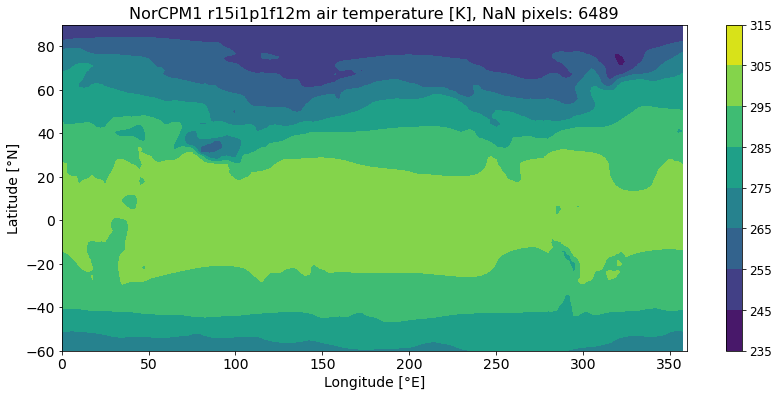

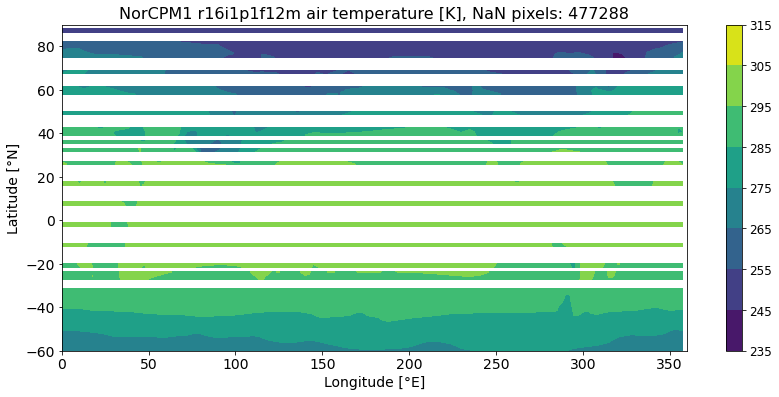

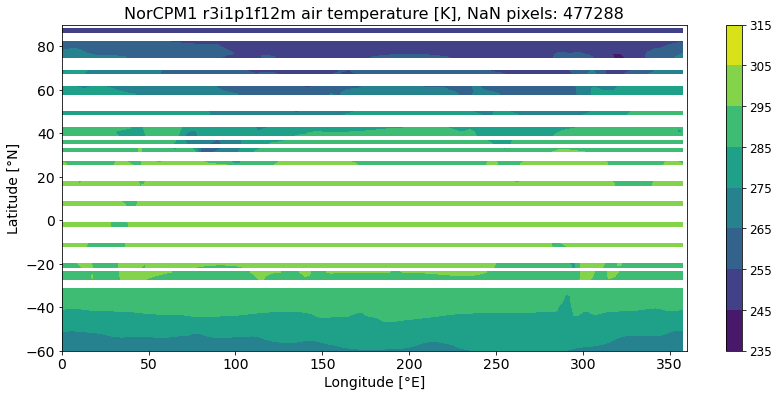

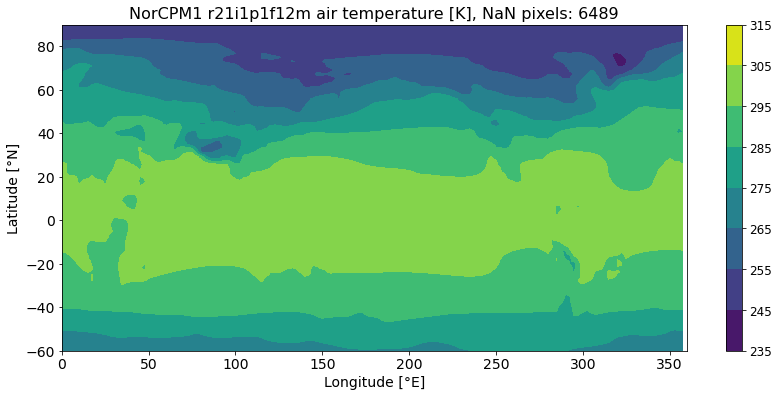

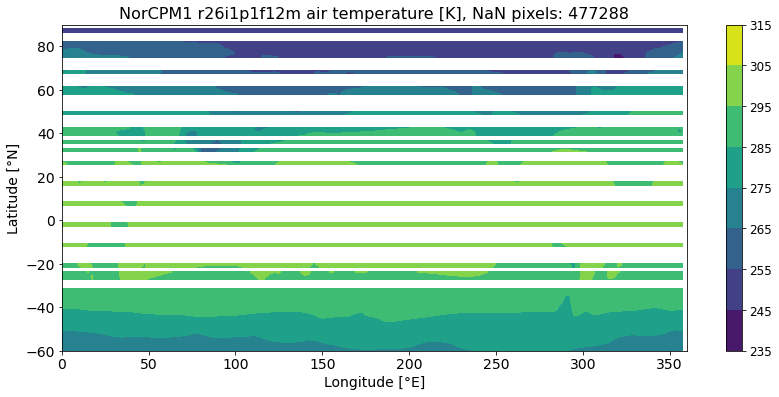

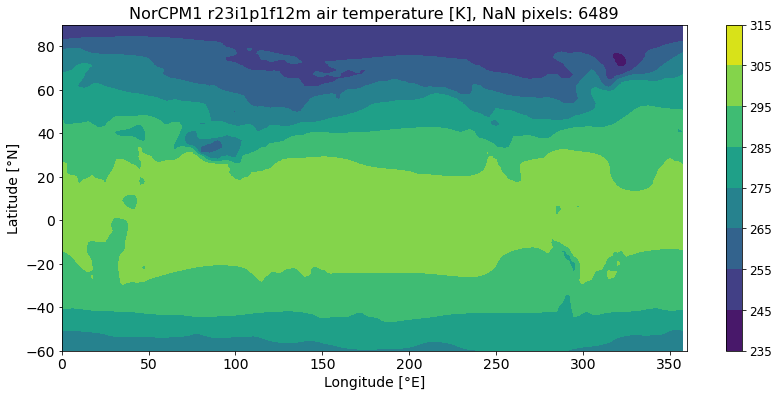

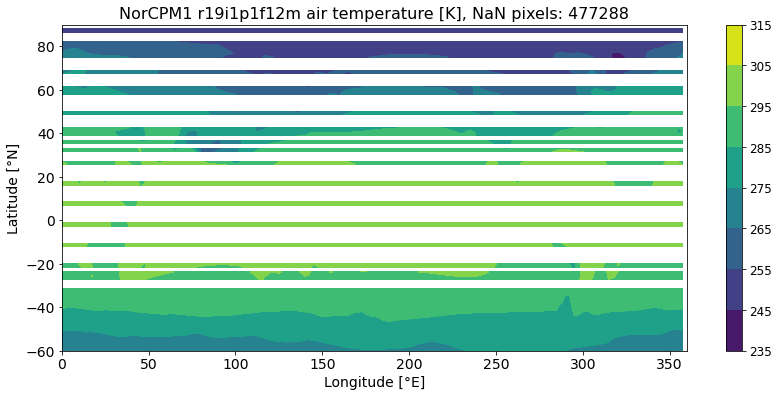

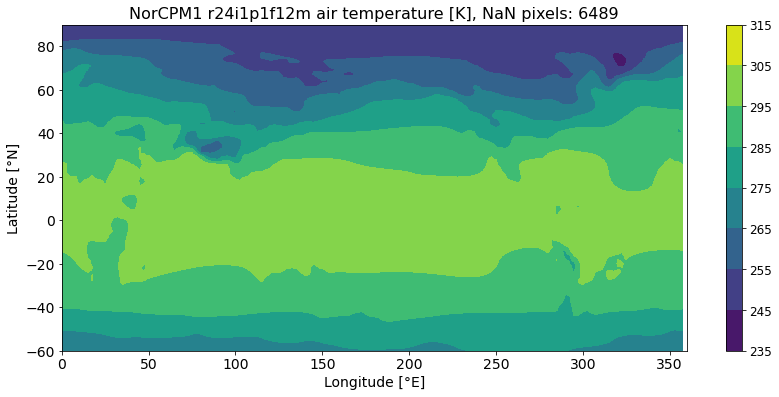

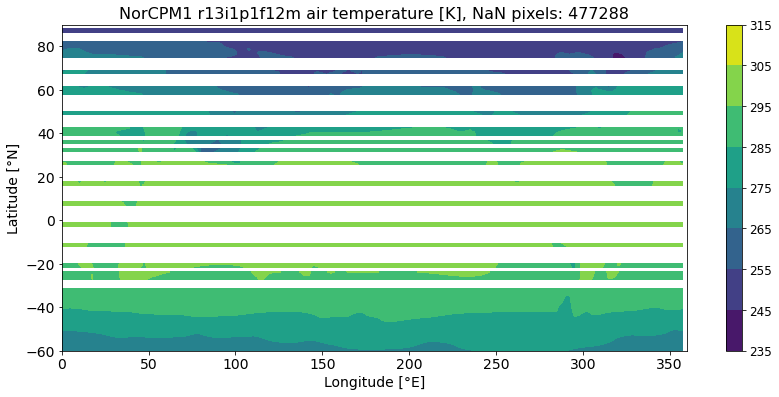

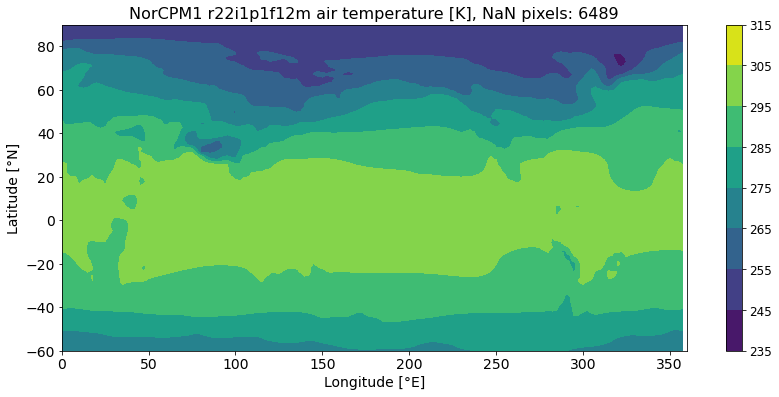

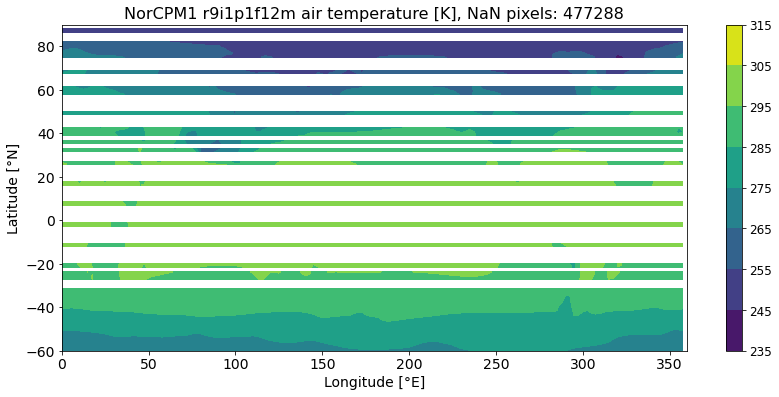

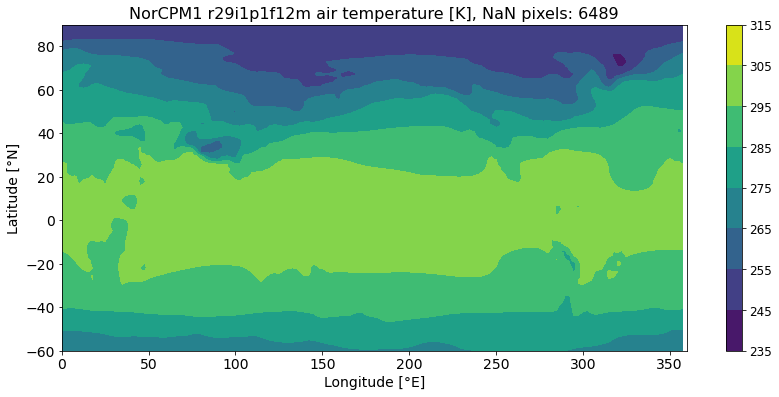

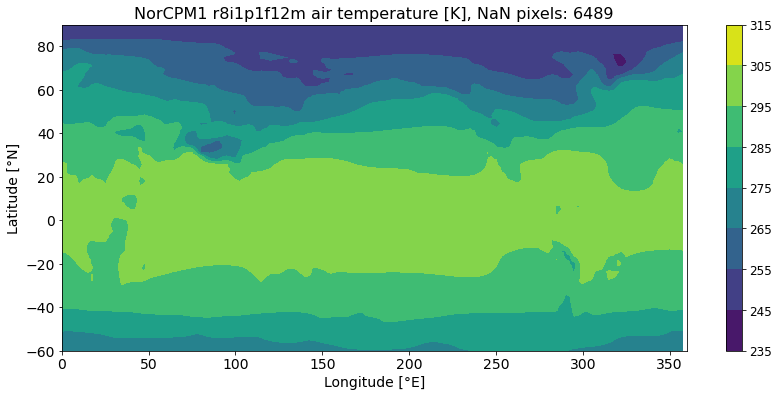

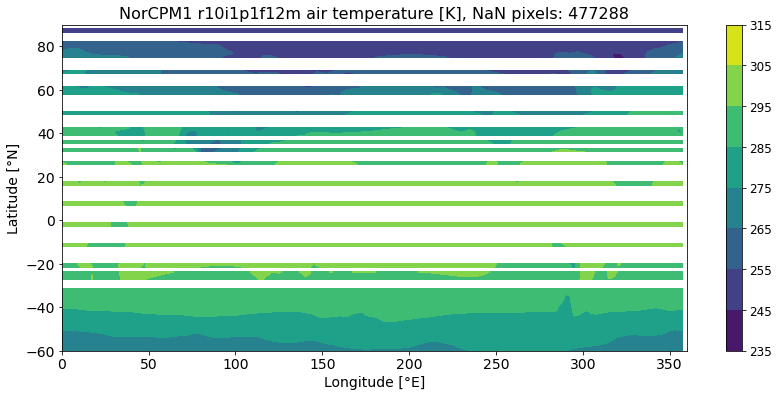

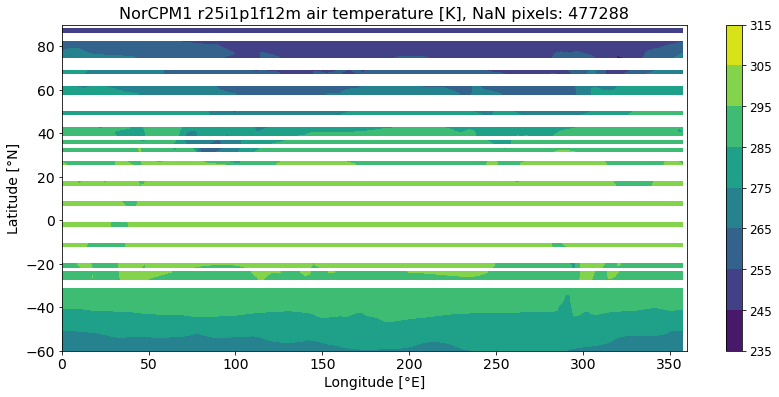

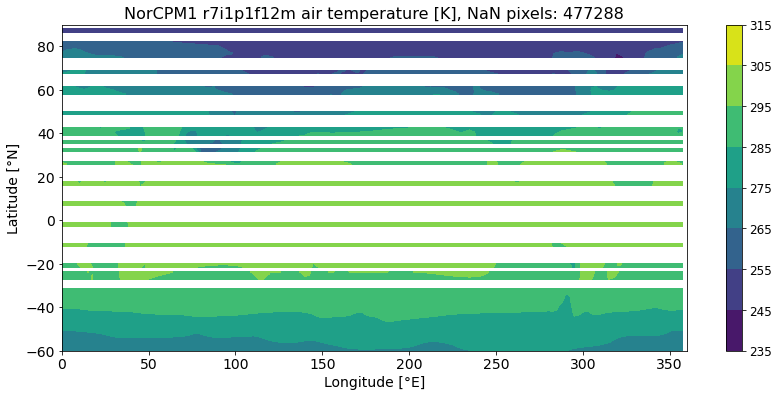

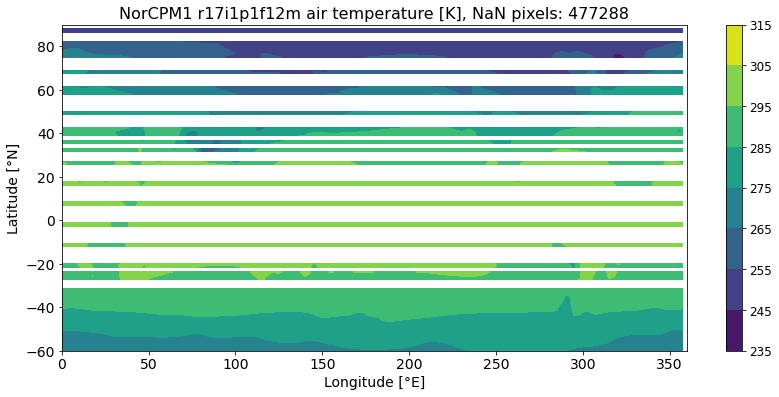

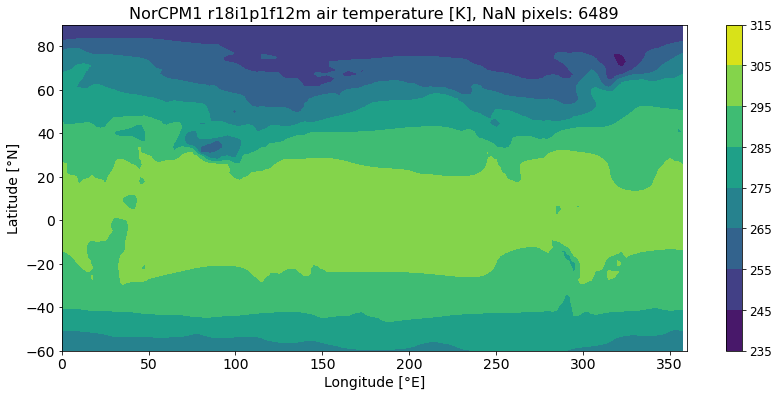

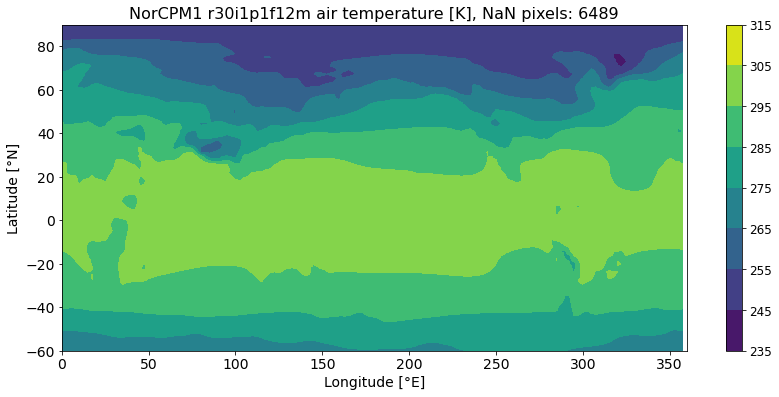

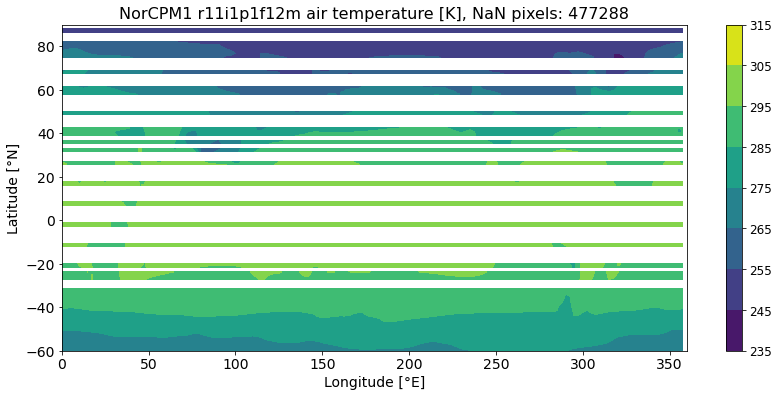

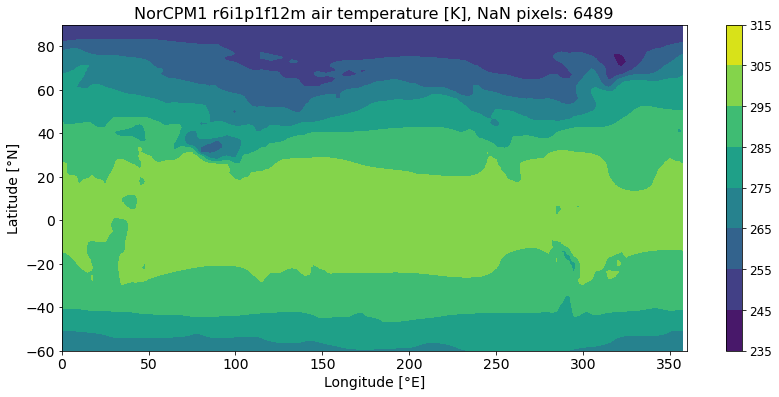

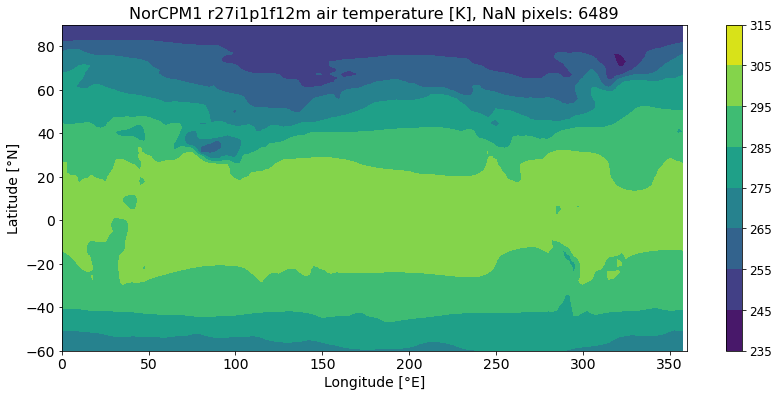

In [7]:
path2members = path2cmip6 + 'NCC/NorCPM1/historical/'
list_of_members_etal = os.listdir(path2members)
# Select only the ensemble members and skip the '.paths.txt' entries.
list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
member_counter = 0

print('Number of ensemble members: '+str(len(list_of_members)))
print('---------------------')

for member in list_of_members: # Print the ensemble members that have info on the mrsos.
    path2files = path2members + member + '/Amon/tas/gn/latest/'
    list_of_files = sorted(os.listdir(path2files))
    if list_of_files: # Check whether there are output files to be read.
        first_file = 1
        for ll in range(len(list_of_files)):
            filename = list_of_files[ll]
            final_date = filename[-9:-3]
            if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                da = xr.open_dataset(path2files + filename)
                if first_file:
                    db = da
                    first_file = 0
                else:
                    db = xr.concat([db,da],dim='time')

        # Select the time window according to the type of time axis.
        if db.time.dtype=='datetime64[ns]':
            instant_start = np.datetime64('1979-01-01')
            instant_end = np.datetime64('2014-12-31')
        else:
            if db.time.values[0].calendar=='noleap':
                instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
            elif db.time.values[0].calendar=='360_day':
                instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

        # Compute the temporal mean in the time frame of interest and interpolate it on the ERA5 grid.        
        d_mean = db[varname].sel(time=slice(instant_start,instant_end)).mean(dim='time')
        d_mean_i = d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)

        fig = plt.figure(figsize=(14,6))
        pc = plt.contourf(lon,lat,d_mean_i.values,levels=levels)
        plt.xlabel('Longitude [°E]',fontsize=14)
        plt.ylabel('Latitude [°N]',fontsize=14)
        plt.ylim([-60,90])
        plt.tick_params(axis='both',labelsize=14)

        cb = plt.colorbar(pc)
        cb.ax.tick_params(labelsize=12)

        plt.title('NorCPM1 ' + member + description +' ['+units+'], NaN pixels: '+ str(np.sum(np.isnan(d_mean_i.values))),fontsize=16)
        
        print(member + ' has '+ str(np.sum(np.isnan(d_mean_i.values))) + ' NaN pixels')
